# Методы интерпретации нейронных сетей

В лабораторной работе предлагается обучить классификатор медицинских изображений на одной из баз MedMNIST (либо другой медицинской базы), применить методы интерпретации нейронных сетей и сопоставить результаты этих методов.

Возможен анализ работы предобученной модели нейронной сети, решающей интересную для вас задачу классификации медицинских изображений.

Удобно использовать реализации методов интерпретации из библиотеки MONAI, специализованной под медицинские задачи (но можно воспользоваться и другими аналогичными библиотеками).

Необходимо исследовать работу обученной нейросетевой модели с помощью методов:
- `OcclusionSensitivity`,
- `GradCAM++`.


Пример обучения нейросетевой модели на MedMNIST из документации:

https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

Примеры использования методов интерпретации из документации проекта MONAI:

https://github.com/Project-MONAI/tutorials/blob/main/modules/interpretability/covid_classification.ipynb

https://github.com/Project-MONAI/tutorials/blob/main/modules/interpretability/class_lung_lesion.ipynb


## Установка зависимостей

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import sklearn" || pip install -q scikit-learn

In [3]:
!pip install medmnist

## Импорт библиотек

In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [5]:
import medmnist
from medmnist import INFO, Evaluator

In [6]:
from monai.config import print_config
from matplotlib import pyplot as plt
from monai.visualize import GradCAMpp, OcclusionSensitivity

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print_config()

MONAI version: 1.4.dev2421
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1070036ea3c30176fc82cfb15952387bed8b8a90
MONAI __file__: /home/<username>/maga/DL/venv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.23.2
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOW

## TODO
#### Создайте необходимые для обучения, валидации и тестирования объекты классов Dataset, DataLoader

In [8]:
from medmnist import DermaMNIST

In [18]:
NUM_EPOCHS = 10
BATCH_SIZE = 64
lr = 0.001

info = INFO["dermamnist"]
task = info["task"]
n_channels = info["n_channels"]
n_classes = len(info["label"])

In [9]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DermaMNIST(split='train', transform=data_transform, download=True)
val_dataset = DermaMNIST(split='val', transform=data_transform, download=True)
test_dataset = DermaMNIST(split='test', transform=data_transform, download=True)

100%|█████████████████████████| 19725078/19725078 [00:08<00:00, 2329805.65it/s]


Using downloaded and verified file: /home/ilya/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/ilya/.medmnist/dermamnist.npz


In [11]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## TODO
#### Создайте объекты классов модели (самостоятельно задав архитектуру сети либо выбрав готовую модель), функции потерь, оптимизатора

In [12]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [19]:
model = Net(in_channels=n_channels, num_classes=n_classes)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (0.5, 0.999))

## TODO
#### Обучите модель, реализовав циклы обучения и валидации

In [20]:
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == "multi-label, binary-class":
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|████████████████████████████████████████| 110/110 [00:02<00:00, 46.08it/s]


In [27]:
def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == "multi-label, binary-class":
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print("%s  auc: %.3f  acc:%.3f" % (split, *metrics))


test("test")

test  auc: 0.917  acc:0.760


# Интерпретируемость

Необходимо сравнить разные методы интерпретации.

## Чувствительность к окклюзии (Occlusion sensitivity)
В этом методе интерпретации последовательно перекрывается часть изображения, а затем отслеживается изменение в предсказанной вероятности предполагаемого класса. Ожидается, что вероятность будет больше снижаться при перекрытии важных частей изображения. Следовательно, синие части изображения характеризуются большей важностью.


## GradCAM
Пользователь выбирает слой сети, который его интересует, и для этого слоя выполняется оценка значимости областей. Обычно выбирается слой из числа последних, так как предполагается, что к этому моменту будут извлечены все необходимые признаки. В сверточных нейронных сетях карты признаков многократно подвергаются уменьшению, поэтому результирующее изображение карты значимости масштабируется в соответствии с размером входного изображения. Как и в случае с чувствительностью к окклюзии, синие участки изображения характеризуются большей важностью для процесса принятия решений.


В отличие от MONAI, в других реализациях методов интерпретации чаще красные оттенки областей соответствуют большим значимостям.

Хорошее объяснение CAM и GradCAM:

https://glassboxmedicine.com/2019/06/11/cnn-heat-maps-class-activation-mapping-cam/

https://glassboxmedicine.com/2020/05/29/grad-cam-visual-explanations-from-deep-networks/

In [28]:
target_layer = "layer5"
gradcampp = GradCAMpp(model, target_layers=target_layer)
occ_sens = OcclusionSensitivity(
    model,
    mask_size=3,
    n_batch=16,
    overlap=0.75,
    verbose=False,
)

In [29]:
info['label']

{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}

In [30]:
def saliency(model, d):
    ims = []

    img = torch.as_tensor(d[0].unsqueeze(0)).to('cpu')

    pred_logits = model(img)
    pred_label = pred_logits.argmax(dim=1).item()
    pred_prob = int(torch.nn.functional.softmax(pred_logits, dim=1)[0, pred_label].item() * 100)
    # Image
    ims.append(img[0])

    gt_label = int(d[1][0])
    massage = f"GT: {info['label'][str(gt_label)]}, "
    massage += f"pred: {info['label'][str(pred_label)]} ({pred_prob}%)"
    print(massage)

    # Occlusion sensitivity images
    occ_map, _ = occ_sens(img)
    ims.append(occ_map[0, pred_label][None])

    # GradCAM
    res_cam_pp = gradcampp(x=img, class_idx=pred_label)[0]
    ims.append(res_cam_pp)

    return ims

GT: vascular lesions, pred: vascular lesions (91%)


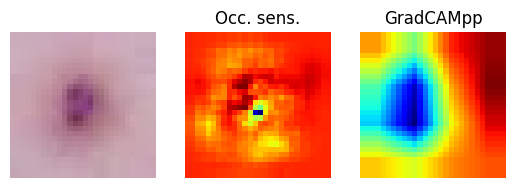

GT: actinic keratoses and intraepithelial carcinoma, pred: basal cell carcinoma (91%)


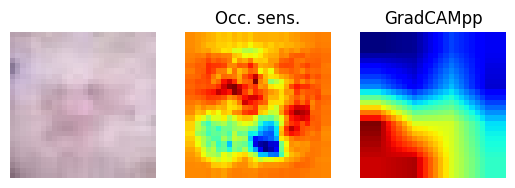

GT: melanocytic nevi, pred: melanocytic nevi (92%)


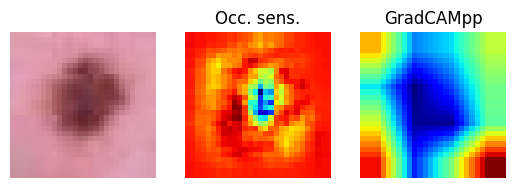

GT: melanocytic nevi, pred: melanocytic nevi (51%)


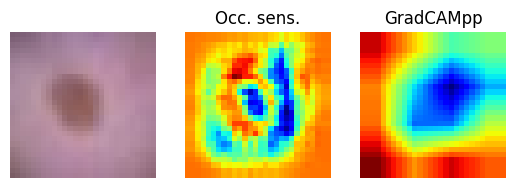

GT: melanocytic nevi, pred: melanocytic nevi (96%)


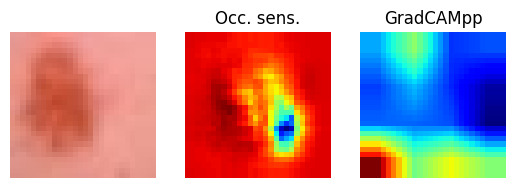

In [31]:
rnd_idxs = np.random.randint(0, high=len(test_dataset), size=5)

for idx in rnd_idxs:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)

    d = test_dataset[idx]

    ims = saliency(model, d)

    im = ims[0].detach().cpu().numpy().transpose(1, 2, 0)
    im = im * 0.5 + 0.5
    ax1.imshow(im)
    ax1.axis("off")

    im = ims[1].detach().cpu().numpy().transpose(1, 2, 0)
    ax2.imshow(im, "jet")
    ax2.set_title("Occ. sens.")
    ax2.axis("off")

    im = ims[2].detach().cpu().numpy().transpose(1, 2, 0)
    ax3.imshow(im, "jet")
    ax3.set_title("GradCAMpp")
    ax3.axis("off")
    plt.show()